In [7]:
#Visualization

#Reliability curves (Weibull fits).

#Demand forecasts vs actuals.

#Safety stock vs base stock scatter.

#ABC–VED heatmap for criticality.

=== KPI SUMMARY ===
Overall Fill Rate      : 19.61%
Overall Stockout Rate  : 80.39%

Coverage (site-part) sample:
  site_id part_id   region  on_hand  daily_rate  coverage_days  base_stock  \
0    S001    P001  Central        6    0.355793      16.863741    5.086604   
1    S001    P002  Central       35    0.470830      74.336824   34.813270   
2    S001    P003  Central        0    0.135990       0.000000    6.823845   
3    S001    P004  Central        2    0.117502      17.020979    5.756964   
4    S001    P005  Central        5    0.222679      22.453875   11.807652   

   safety_stock  
0      2.596053  
1      8.446795  
2      3.152111  
3      2.819413  
4      4.459254  

ABC distribution:
ABC
C    47
A    29
B    24
Name: count, dtype: int64

VED distribution:
VED
D    48
E    40
V    12
Name: count, dtype: int64


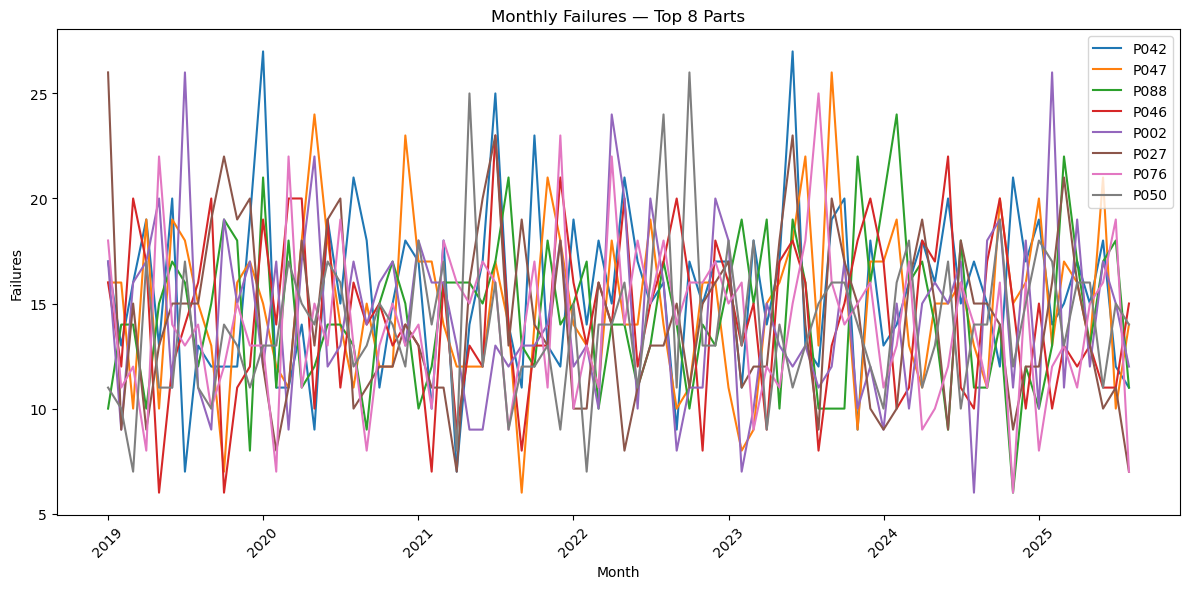

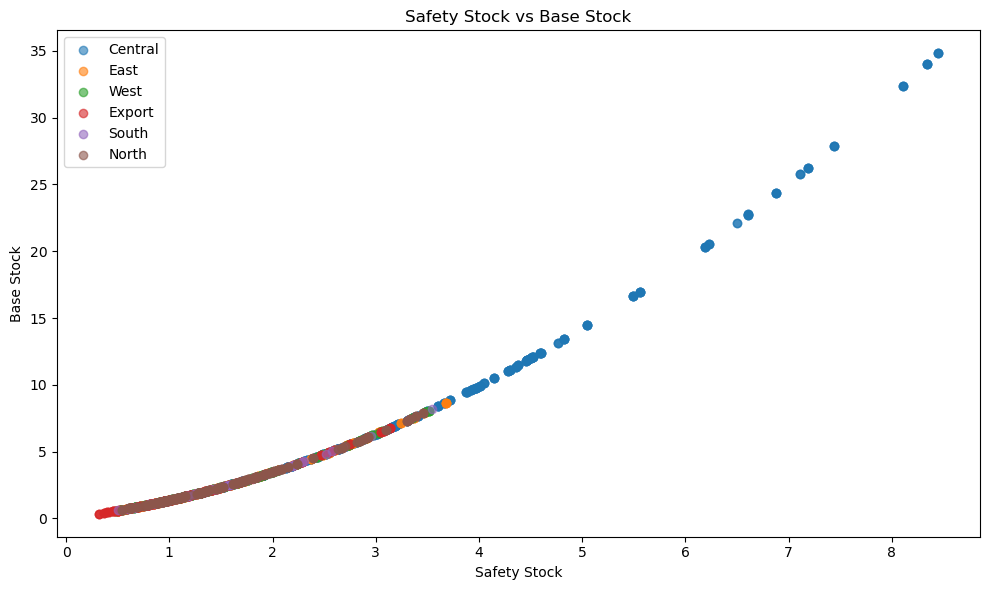

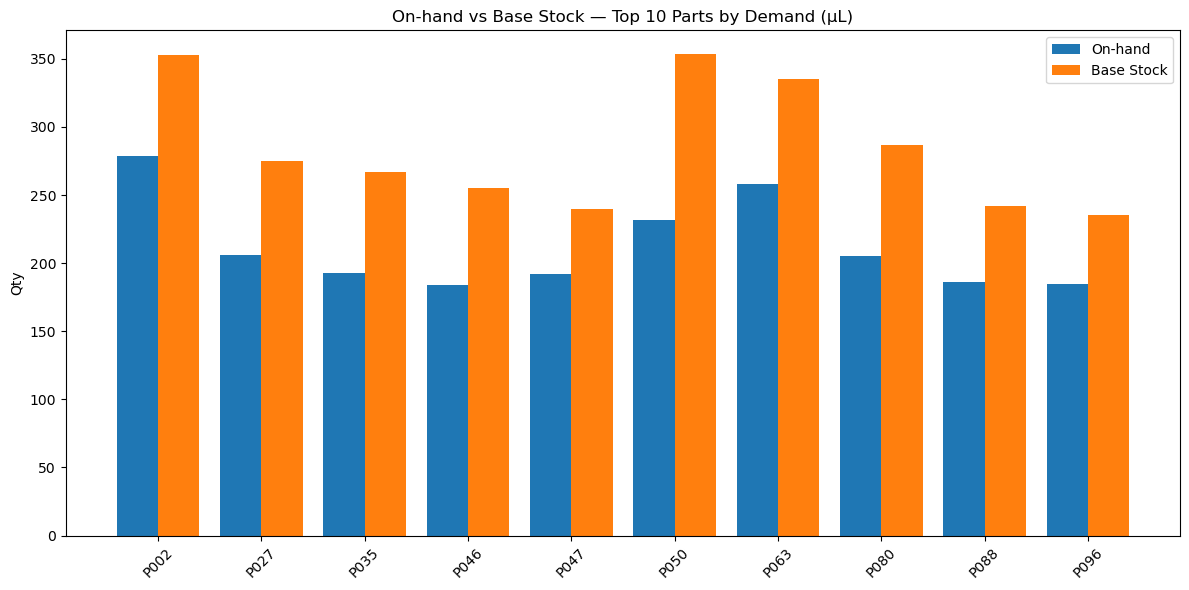

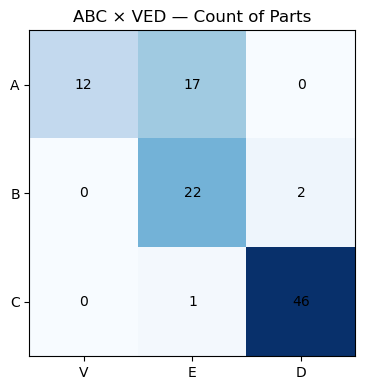

In [9]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 0) Loading utilities
# -----------------------------
def load_data(base_path: str = "."):
    """Load all core CSVs from base_path. Returns dict of DataFrames."""
    def _p(fn): return os.path.join(base_path, fn)

    parts  = pd.read_csv(_p("parts_master (1).csv"))
    sites  = pd.read_csv(_p("sites (1).csv"))
    failures = pd.read_csv(_p("failures (1).csv"), parse_dates=["failure_date"])
    policy = pd.read_csv(_p("policy_base_stock (1).csv"))
    inventory = pd.read_csv(_p("inventory_snapshots (1).csv"))
    orders = pd.read_csv(_p("service_orders (1).csv"), parse_dates=["request_date","fulfill_date"])

    # Optional tables if present
    population = pd.read_csv(_p("population_in_field (1).csv")) if os.path.exists(_p("population_in_field (1).csv")) else None
    reliability = pd.read_csv(_p("reliability_priors (1).csv")) if os.path.exists(_p("reliability_priors (1).csv")) else None
    usage = pd.read_csv(_p("part_usage_matrix (1).csv")) if os.path.exists(_p("part_usage_matrix (1).csv")) else None

    return {
        "parts": parts,
        "sites": sites,
        "failures": failures,
        "policy": policy,
        "inventory": inventory,
        "orders": orders,
        "population": population,
        "reliability": reliability,
        "usage": usage
    }

# -----------------------------
# 1) KPI calculations
# -----------------------------
def calc_fill_rate(orders: pd.DataFrame, by: list | None = None) -> pd.DataFrame | float:
    """
    Fill rate = 1 - stockout_rate. If `by` is None, returns a scalar (float).
    Otherwise returns DataFrame grouped by the given columns (e.g., ['part_id'], ['site_id'], ['site_id','part_id']).
    """
    if orders.empty:
        return 1.0 if by is None else pd.DataFrame()

    if by is None:
        return float(1 - orders["stockout_flag"].mean())

    g = orders.groupby(by)["stockout_flag"].mean().reset_index()
    g["fill_rate"] = 1 - g["stockout_flag"]
    g = g.drop(columns=["stockout_flag"])
    return g

def calc_stockout_rate(orders: pd.DataFrame, by: list | None = None) -> pd.DataFrame | float:
    """
    Stockout rate = mean(stockout_flag). Returns scalar if `by` None, else grouped DataFrame (in %).
    """
    if orders.empty:
        return 0.0 if by is None else pd.DataFrame()

    if by is None:
        return float(orders["stockout_flag"].mean())

    g = orders.groupby(by)["stockout_flag"].mean().reset_index()
    g["stockout_%"] = g["stockout_flag"] * 100
    return g.drop(columns=["stockout_flag"])

def calc_coverage_days(policy: pd.DataFrame, inventory: pd.DataFrame, by_site_part: bool = True) -> pd.DataFrame:
    """
    Coverage days = on_hand / daily_rate (avoid division by 0 with small epsilon).
    If by_site_part is True (default), returns site-part level coverage. Otherwise aggregates by part_id.
    """
    merged = policy.merge(inventory, on=["site_id","part_id"])
    # Avoid divide by zero
    daily_rate = merged["daily_rate"].replace(0, 0.01)
    merged["coverage_days"] = merged["on_hand"] / daily_rate

    if by_site_part:
        return merged[["site_id","part_id","region","on_hand","daily_rate","coverage_days","base_stock","safety_stock"]]
    else:
        agg = (merged.groupby("part_id")
                      .agg(on_hand=("on_hand","sum"),
                           daily_rate=("daily_rate","sum"),
                           base_stock=("base_stock","sum"),
                           safety_stock=("safety_stock","sum"))
                      .reset_index())
        agg["coverage_days"] = agg["on_hand"] / agg["daily_rate"].replace(0, 0.01)
        return agg

# -----------------------------
# 2) ABC–VED classification
# -----------------------------
def abc_analysis(parts: pd.DataFrame, policy: pd.DataFrame, value_col: str = "value_demand") -> pd.DataFrame:
    """
    ABC based on cumulative demand value across sites: sum(muL * unit_cost) per part.
    Returns DataFrame with columns: part_id, demand_value, cum_share, ABC.
    """
    # Merge muL and costs
    val = (policy[["part_id","muL"]]
           .groupby("part_id", as_index=False)["muL"].sum()
           .merge(parts[["part_id","unit_cost"]], on="part_id", how="left"))
    val["demand_value"] = val["muL"] * val["unit_cost"]
    val = val.sort_values("demand_value", ascending=False).reset_index(drop=True)

    total = val["demand_value"].sum()
    if total <= 0:
        val["cum_share"] = 0.0
        val["ABC"] = "C"
        return val[["part_id","demand_value","cum_share","ABC"]]

    val["cum_share"] = val["demand_value"].cumsum() / total
    # Thresholds: A=top ~70–80% value, B=next ~15–25%, C=rest
    val["ABC"] = np.where(val["cum_share"] <= 0.80, "A",
                   np.where(val["cum_share"] <= 0.95, "B", "C"))
    return val[["part_id","demand_value","cum_share","ABC"]]

def ved_analysis(parts: pd.DataFrame, policy: pd.DataFrame) -> pd.DataFrame:
    """
    VED criticality using a simple severity score combining:
      - Lead time (normalized)
      - Unit cost (normalized)
      - Failure intensity (daily_rate aggregated across sites, normalized)
    Returns part_id, severity_score, VED.
    """
    # Aggregate daily_rate across sites for each part
    rate = policy.groupby("part_id", as_index=False)["daily_rate"].sum().rename(columns={"daily_rate":"rate"})
    feat = parts[["part_id","unit_cost","lead_time_days"]].merge(rate, on="part_id", how="left")
    feat["rate"] = feat["rate"].fillna(0)

    def _norm(x):
        x = x.astype(float)
        if x.max() == x.min():
            return pd.Series(np.zeros(len(x)))
        return (x - x.min()) / (x.max() - x.min())

    feat["lt_n"]   = _norm(feat["lead_time_days"])
    feat["cost_n"] = _norm(feat["unit_cost"])
    feat["rate_n"] = _norm(feat["rate"])

    # Weighted severity (tweak weights if needed)
    feat["severity_score"] = 0.45*feat["lt_n"] + 0.35*feat["cost_n"] + 0.20*feat["rate_n"]

    # Map to V/E/D with 0.66 / 0.33 cutoffs
    feat["VED"] = np.where(feat["severity_score"] >= 0.66, "V",
                    np.where(feat["severity_score"] >= 0.33, "E", "D"))

    return feat[["part_id","severity_score","VED"]]

def abc_ved_matrix(abc_df: pd.DataFrame, ved_df: pd.DataFrame) -> pd.DataFrame:
    """
    Combine ABC and VED into matrix; returns part_id, ABC, VED, class (e.g., A-V, B-E, etc.).
    """
    out = abc_df.merge(ved_df, on="part_id", how="outer")
    out["class"] = out["ABC"].fillna("C") + "-" + out["VED"].fillna("D")
    return out[["part_id","ABC","VED","class","demand_value","severity_score","cum_share"]]

# -----------------------------
# 3) Visualizations (Matplotlib)
# -----------------------------
def plot_monthly_failures_topN(failures: pd.DataFrame, top_n: int = 8):
    """
    Line plot of monthly failures for top-N failing parts.
    """
    if failures.empty:
        print("No failures to plot.")
        return
    df = failures.copy()
    # Convert to month timestamps (fixes Period plotting issues)
    df["month"] = df["failure_date"].dt.to_period("M").dt.to_timestamp()
    top_parts = df.groupby("part_id").size().sort_values(ascending=False).head(top_n).index.tolist()
    sub = (df[df["part_id"].isin(top_parts)]
           .groupby(["month","part_id"])
           .size().reset_index(name="failures"))

    plt.figure(figsize=(12,6))
    for p in top_parts:
        s = sub[sub["part_id"] == p]
        plt.plot(s["month"], s["failures"], label=p)
    plt.title(f"Monthly Failures — Top {top_n} Parts")
    plt.xlabel("Month"); plt.ylabel("Failures")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_safety_vs_base(policy: pd.DataFrame, sample_n: int = 2000, alpha: float = 0.6):
    """
    Scatter: safety stock vs base stock (sampled to avoid overplotting). Colored by region via legend grouping.
    """
    if policy.empty:
        print("Policy table is empty.")
        return
    sample = policy.sample(n=min(sample_n, len(policy)), random_state=42)
    plt.figure(figsize=(10,6))
    for r in sample["region"].unique():
        s = sample[sample["region"] == r]
        plt.scatter(s["safety_stock"], s["base_stock"], alpha=alpha, label=r)
    plt.title("Safety Stock vs Base Stock")
    plt.xlabel("Safety Stock"); plt.ylabel("Base Stock")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_onhand_vs_basestock_top(parts: pd.DataFrame, policy: pd.DataFrame, inventory: pd.DataFrame, top_n: int = 10):
    """
    Bars: aggregated On-hand vs Base Stock for top-N parts by total muL (lead-time demand).
    """
    if policy.empty or inventory.empty:
        print("Policy/Inventory tables are empty.")
        return
    demand_by_part = policy.groupby("part_id")["muL"].sum().sort_values(ascending=False).head(top_n).index.tolist()
    inv = inventory.merge(policy[["site_id","part_id","base_stock"]], on=["site_id","part_id"], how="left")
    inv = inv[inv["part_id"].isin(demand_by_part)]

    agg = inv.groupby("part_id")[["on_hand","base_stock"]].sum().reset_index()
    x = np.arange(len(agg))
    w = 0.4
    plt.figure(figsize=(12,6))
    plt.bar(x, agg["on_hand"], width=w, label="On-hand")
    plt.bar(x+w, agg["base_stock"], width=w, label="Base Stock")
    plt.xticks(x + w/2, agg["part_id"], rotation=45)
    plt.title(f"On-hand vs Base Stock — Top {top_n} Parts by Demand (μL)")
    plt.ylabel("Qty")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_abc_ved_heatmap(matrix_df: pd.DataFrame):
    """
    Heatmap-like table (text) showing counts per ABC x VED cell using matplotlib.
    """
    if matrix_df.empty:
        print("ABC–VED matrix is empty.")
        return
    pivot = (matrix_df
             .assign(count=1)
             .pivot_table(index="ABC", columns="VED", values="count", aggfunc="sum", fill_value=0)
             .reindex(index=["A","B","C"], columns=["V","E","D"], fill_value=0))

    fig, ax = plt.subplots(figsize=(6,4))
    im = ax.imshow(pivot.values, cmap="Blues")
    ax.set_xticks(np.arange(pivot.shape[1]), labels=pivot.columns)
    ax.set_yticks(np.arange(pivot.shape[0]), labels=pivot.index)
    plt.title("ABC × VED — Count of Parts")

    # annotate cells
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            ax.text(j, i, str(pivot.values[i, j]), ha="center", va="center", color="black")

    plt.tight_layout()
    plt.show()

# -----------------------------
# 4) End-to-end convenience
# -----------------------------
def run_all(base_path: str = ".", top_n_fail: int = 8, top_n_onhand: int = 10):
    """
    Load data, print KPIs, compute ABC–VED, and show all charts.
    """
    data = load_data(base_path)
    parts, sites = data["parts"], data["sites"]
    failures, policy = data["failures"], data["policy"]
    inventory, orders = data["inventory"], data["orders"]

    # KPIs
    overall_fill = calc_fill_rate(orders)
    overall_stockout = calc_stockout_rate(orders)

    print("=== KPI SUMMARY ===")
    print(f"Overall Fill Rate      : {overall_fill:.2%}")
    print(f"Overall Stockout Rate  : {overall_stockout:.2%}")

    cov_sp = calc_coverage_days(policy, inventory, by_site_part=True)
    print("\nCoverage (site-part) sample:")
    print(cov_sp.head())

    # ABC–VED
    abc = abc_analysis(parts, policy)
    ved = ved_analysis(parts, policy)
    matrix = abc_ved_matrix(abc, ved)
    print("\nABC distribution:")
    print(abc["ABC"].value_counts())
    print("\nVED distribution:")
    print(ved["VED"].value_counts())

    # Charts
    plot_monthly_failures_topN(failures, top_n=top_n_fail)
    plot_safety_vs_base(policy, sample_n=2000)
    plot_onhand_vs_basestock_top(parts, policy, inventory, top_n=top_n_onhand)
    plot_abc_ved_heatmap(matrix)

    return {
        "coverage_site_part": cov_sp,
        "abc": abc,
        "ved": ved,
        "abc_ved_matrix": matrix
    }

# -----------------------------
# 5) Example usage (run directly)
# -----------------------------
if __name__ == "__main__":
    # Point base_path to the folder where the CSVs are located.
    # If this file sits in the same folder as the CSVs, you can leave default "."
    results = run_all(base_path=".")
    # Access computed tables:
    # results["coverage_site_part"], results["abc"], results["ved"], results["abc_ved_matrix"]
